# Shor's Algorithm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
%matplotlib inline

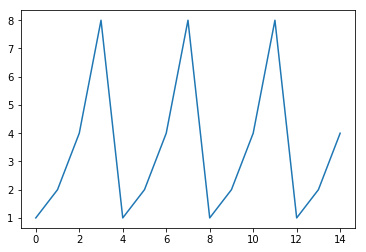

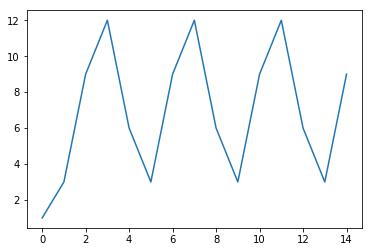

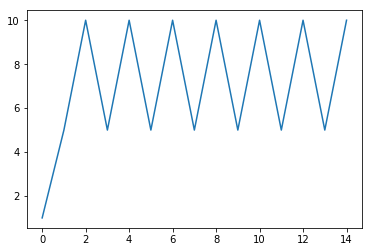

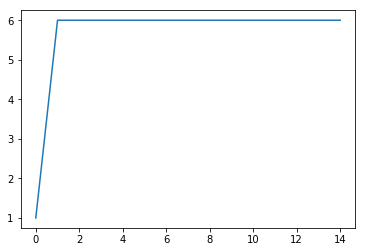

In [3]:
def sigmoid_demo(a=2, N=15, xmax=15):
    xs = list(range(xmax))
    ys = [pow(a, x, N) for x in xs]
    plt.plot(xs, ys)

interactive(sigmoid_demo, a=(1,20), N=(1,20), xmax=(1, 100))